Author: Nicolas Saenz
Date: 12-15-2025
DSC 680
XGBoost Model built to predict the number INaturalist Observations

In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


import plotly.express as px
from sklearn.decomposition import PCA

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

from sklearn.model_selection import GroupKFold

import seaborn as sns

In [2]:
#make datasets uniform with lowercase function
def lowercase(val):
    if isinstance(val, str):
        return val.lower()
    return val

In [3]:
#contains city observation data by month

df_city_month = pd.read_csv('INat city observation by month2.csv')

df_city_month = df_city_month.map(lowercase)

print(df_city_month.head(24))

# ['observers','observer int speices / observer','Species diversity count']

df_city_month = df_city_month.drop(columns=[])


    Month         City  Observation number all species  \
0       1  albuquerque                            5804   
1       2  albuquerque                            9022   
2       3  albuquerque                           12578   
3       4  albuquerque                           87004   
4       5  albuquerque                           50516   
5       6  albuquerque                           34257   
6       7  albuquerque                           30312   
7       8  albuquerque                           32091   
8       9  albuquerque                           41205   
9      10  albuquerque                           24974   
10     11  albuquerque                           14338   
11     12  albuquerque                            9627   
12      1    anchorage                             643   
13      2    anchorage                             933   
14      3    anchorage                            1506   
15      4    anchorage                            3180   
16      5    a

In [4]:
#Parks and Population density data for cities

df_City_park_Density = pd.read_csv('Combined_City_park_Density_TPL.csv')

df_City_park_Density  = df_City_park_Density.map(lowercase)

# Assuming your dataframe is named 'df'
df_City_park_Density['City_Name'] = df_City_park_Density['City_Name'].str.replace('_', ' ')

print(df_City_park_Density.head())

     City_Name State_Abv  Population              Growth  Adjusted_Land_Area  \
0  albuquerque        nm      564818         medium fast              114528   
1      anaheim        ca      342574  limited or decline               31730   
2    anchorage        ak      287385         medium slow             1083714   
3    arlington        tx      400468         medium fast               60641   
4    arlington        va      251249         medium fast               15871   

   Density_People_Per_Acre  Total_Acres  % Natural  % Designed  \
0                      4.9        21010   0.853070    0.146930   
1                     10.8         4618   0.859463    0.140537   
2                      0.3       914622   0.997227    0.002773   
3                      6.6         5639   0.330023    0.669977   
4                     15.8         1800   0.476111    0.523889   

   Acres_per _1000 people  Parks_as_Percent_City_Area  
0               37.197820                    0.183449  
1         

In [5]:
#Parks and Population density data for cities

df_Temp_Data = pd.read_csv('US_City_Temp_Data.csv')

df_Temp_Data  = df_Temp_Data.map(lowercase)

df_Temp_Data.rename(columns={'salt_lake_city': 'salt_lake'}, inplace=True)

df_Temp_Data.columns = df_Temp_Data.columns.str.replace('_', ' ')

print(df_Temp_Data.head())

         time  albuquerque  anchorage    atlanta      boise     boston  \
0  1948-01-01    -0.440002  -5.979980   3.420013  -0.600006  -5.989990   
1  1948-02-01     1.649994  -9.000000   9.110016   0.130005  -4.350006   
2  1948-03-01     3.470001  -5.850006  13.640015   2.309998   2.410004   
3  1948-04-01    13.240021  -0.269989  18.660004   7.250000   8.130005   
4  1948-05-01    16.910004   6.730011  21.540009  11.860016  12.770020   

     buffalo  charlotte    chicago     dallas  ...   portland  rapid city  \
0  -7.790008   2.390015  -7.339996   4.529999  ...   3.920013   -4.029999   
1  -4.549988   6.670013  -3.139984   8.589996  ...   4.029999   -5.549988   
2   1.160004  12.520020   2.950012  12.640015  ...   6.220001   -1.250000   
3   8.690002  17.279999  12.149994  21.869995  ...   8.100006    9.480011   
4  11.320007  20.619995  13.700012  23.800018  ...  12.230011   13.270020   

       reno   richmond  sacramento  salt lake  san antonio  san francisco  \
0  0.250000   0

In [13]:
#Clean up temp data further modern years 2021 forward and simplifying time column
df_Temp_Data['time'] = pd.to_datetime(df_Temp_Data['time'])

df_filtered = df_Temp_Data[df_Temp_Data['time'].dt.year >= 2021].copy()

print(f"Data filtered. Rows remaining: {len(df_filtered)}")

print(df_filtered.head())


Data filtered. Rows remaining: 23
          time  albuquerque  anchorage    atlanta      boise     boston  \
876 2021-01-01     1.822021  -3.834229   7.290771   1.540771  -0.584229   
877 2021-02-01     4.282654  -8.186096   7.970154   1.220154  -1.436096   
878 2021-03-01     7.799408  -6.044342  14.330658   5.486908   4.518158   
879 2021-04-01    12.741241   1.678742  16.116241   9.709991   9.616241   
880 2021-05-01    18.263031   8.200531  20.700531  13.825531  14.888031   

       buffalo  charlotte    chicago     dallas  ...   portland  rapid city  \
876  -1.865479   5.853271  -2.396729   9.009521  ...   6.478271   -0.552979   
877  -4.654846   6.563904  -7.248596   5.407654  ...   5.157654   -8.654846   
878   3.518158  12.768158   6.486908  16.236908  ...   7.330658    4.705658   
879   7.928742  15.709991  10.647491  17.928741  ...  11.022491    6.584992   
880  12.794281  19.919281  15.356781  22.325531  ...  13.888031   12.606781   

          reno   richmond  sacramento  s

In [15]:
# Convert the time column to datetime
df_filtered['time'] = pd.to_datetime(df_filtered['time'])

#Replace time values with the Month Number (1-12)
df_filtered2 = df_filtered.copy() 
df_filtered2['time'] = df_filtered['time'].dt.month

# Rename column time to Month
df_filtered2 = df_filtered2.rename(columns={'time': 'Month'})

# Group by the 'Month' column and calculate the mean of all other numeric columns
monthly_averages = df_filtered2.groupby('Month').mean()

# Move 'Month' back to being a regular column
monthly_averages = monthly_averages.reset_index()

print(monthly_averages)

# Save the final result
monthly_averages.to_csv('monthly_averages.csv', index=False)

    Month  albuquerque  anchorage    atlanta      boise     boston    buffalo  \
0       1     2.046478  -5.047272   6.624603  -0.172272  -2.219147  -4.297272   
1       2     3.338196  -4.989929   8.885071   1.025696  -0.755554  -4.052429   
2       3     7.770416  -2.932709  13.926666   6.098541   4.457916   2.786041   
3       4    13.504684   2.192184  16.192184   8.020309   9.410934   7.348434   
4       5    18.775437   8.619186  21.791062  12.634811  15.556687  13.791061   
5       6    24.068070  13.450882  25.716507  20.122757  20.497757  19.419632   
6       7    25.758805  14.008805  26.899430  25.586930  23.086930  20.993180   
7       8    24.083924  12.787049  26.318299  23.849549  24.099549  21.927674   
8       9    21.319580   8.678955  22.960205  18.116455  18.616455  17.319580   
9      10    13.008591   3.086716  17.227341  11.383591  13.446091  12.227341   
10     11     6.835739  -6.398636  11.648239   2.788864   6.976364   5.273239   
11     12     4.829193  -7.4

In [17]:
# Creates a new dataframe with 3 columns Month, City, and Temperature
monthly_averages = monthly_averages.melt(id_vars=['Month'], 
                         var_name='City', 
                         value_name='Temperature')

monthly_averages['comfort_range'] = monthly_averages['Temperature'].apply(
    lambda x: 1 if 4.44 <= x <= 25.4 else 0
)

#print(monthly_averages)
print(monthly_averages.head(24))

    Month         City  Temperature  comfort_range
0       1  albuquerque     2.046478              0
1       2  albuquerque     3.338196              0
2       3  albuquerque     7.770416              1
3       4  albuquerque    13.504684              1
4       5  albuquerque    18.775437              1
5       6  albuquerque    24.068070              1
6       7  albuquerque    25.758805              0
7       8  albuquerque    24.083924              1
8       9  albuquerque    21.319580              1
9      10  albuquerque    13.008591              1
10     11  albuquerque     6.835739              1
11     12  albuquerque     4.829193              1
12      1    anchorage    -5.047272              0
13      2    anchorage    -4.989929              0
14      3    anchorage    -2.932709              0
15      4    anchorage     2.192184              0
16      5    anchorage     8.619186              1
17      6    anchorage    13.450882              1
18      7    anchorage    14.00

In [19]:
final_df_temp_observe = pd.merge(df_city_month, monthly_averages, on=['Month', 'City'], how='left')

print(final_df_temp_observe.head())

final_df_temp_observe.to_csv('final_df_temp_observe.csv', index=False)

   Month         City  Observation number all species  \
0      1  albuquerque                            5804   
1      2  albuquerque                            9022   
2      3  albuquerque                           12578   
3      4  albuquerque                           87004   
4      5  albuquerque                           50516   

   Species diversity count  observers  observer int speices / observer  \
0                      772        731                         1.056088   
1                     1089        918                         1.186275   
2                     1568       1449                         1.082126   
3                     3551       3310                         1.072810   
4                     3377       3136                         1.076849   

   Temperature  comfort_range  
0     2.046478            0.0  
1     3.338196            0.0  
2     7.770416            1.0  
3    13.504684            1.0  
4    18.775437            1.0  


In [21]:
#contains city observation data by month
df_City_park_Density = pd.read_csv('Combined_City_park_Density_TPL.csv')

df_City_park_Density = df_City_park_Density.map(lowercase)

# Rename column 'time' to 'Month'
df_City_park_Density = df_City_park_Density.rename(columns={'City_Name': 'City'})

print(df_City_park_Density.head(24))

                City State_Abv  Population              Growth  \
0        albuquerque        nm      564818         medium fast   
1            anaheim        ca      342574  limited or decline   
2          anchorage        ak      287385         medium slow   
3          arlington        tx      400468         medium fast   
4          arlington        va      251249         medium fast   
5            atlanta        ga      525056         medium fast   
6             aurora        co      405469         medium fast   
7             austin        tx     1017092           very fast   
8        bakersfield        ca      416018           very fast   
9          baltimore        md      568173  limited or decline   
10             boise        id      243738         medium fast   
11            boston        ma      662284         medium slow   
12           buffalo        ny      281080  limited or decline   
13          chandler        az      285784           very fast   
14        

In [23]:
# Merge population data into observation data using 'City' as the key
final_dataset = pd.merge(monthly_averages, df_City_park_Density, on='City', how='left')

# Check the first few rows to confirm columns like 'Population' and 'Growth' were added
print(final_dataset.head())


   Month         City  Temperature  comfort_range State_Abv  Population  \
0      1  albuquerque     2.046478              0        nm    564818.0   
1      2  albuquerque     3.338196              0        nm    564818.0   
2      3  albuquerque     7.770416              1        nm    564818.0   
3      4  albuquerque    13.504684              1        nm    564818.0   
4      5  albuquerque    18.775437              1        nm    564818.0   

        Growth  Adjusted_Land_Area  Density_People_Per_Acre  Total_Acres  \
0  medium fast            114528.0                      4.9      21010.0   
1  medium fast            114528.0                      4.9      21010.0   
2  medium fast            114528.0                      4.9      21010.0   
3  medium fast            114528.0                      4.9      21010.0   
4  medium fast            114528.0                      4.9      21010.0   

   % Natural  % Designed  Acres_per _1000 people  Parks_as_Percent_City_Area  
0    0.85307 

In [25]:
final_df = pd.merge(final_df_temp_observe, final_dataset, on=['Month', 'City'], how='left')

final_df = final_df.drop(columns=['Parks_as_Percent_City_Area','Acres_per _1000 people','Total_Acres','State_Abv','Growth','Adjusted_Land_Area'])

print(final_df.head())

final_df.to_csv('final_df.csv', index=False)

   Month         City  Observation number all species  \
0      1  albuquerque                            5804   
1      2  albuquerque                            9022   
2      3  albuquerque                           12578   
3      4  albuquerque                           87004   
4      5  albuquerque                           50516   

   Species diversity count  observers  observer int speices / observer  \
0                      772        731                         1.056088   
1                     1089        918                         1.186275   
2                     1568       1449                         1.082126   
3                     3551       3310                         1.072810   
4                     3377       3136                         1.076849   

   Temperature_x  comfort_range_x  Temperature_y  comfort_range_y  Population  \
0       2.046478              0.0       2.046478              0.0    564818.0   
1       3.338196              0.0       3.338196  

In [28]:
# Calculate Total Observations per City
city_sizes = final_df.groupby('City')['Observation number all species'].sum().sort_values(ascending=False)

print("Top 5 Biggest Cities:")
print(city_sizes.head())

# Create the Split Lists (Systematic Sampling)
# We take every city in the list.
# Train = Indices 0, 1, 2, 3 (Skip 4)
# Test  = Index 4, 9, 14(Every 5th city)

unique_cities_sorted = city_sizes.index.tolist()


test_cities = unique_cities_sorted[4::5] 

train_cities = [c for c in unique_cities_sorted if c not in test_cities]


# Apply the Split (Standard logic)
final_df['Split_Column'] = final_df['City'].apply(lambda x: 'Test' if x in test_cities else 'Train')

# Verify the Balance
print("-" * 30)
print(f"Train Cities: {len(train_cities)}")
print(f"Test Cities:  {len(test_cities)}")

# Check if the "Max" is now balanced
train_max = final_df[final_df['Split_Column'] == 'Train']['Observation number all species'].max()
test_max = final_df[final_df['Split_Column'] == 'Test']['Observation number all species'].max()

print(f"New Train Max: {train_max}")
print(f"New Test Max:  {test_max}")

Top 5 Biggest Cities:
City
los_angeles    3130889
minneapolis    1016402
san_antonio     925596
new_york        924390
portland        886034
Name: Observation number all species, dtype: int64
------------------------------
Train Cities: 28
Test Cities:  7
New Train Max: 501927
New Test Max:  143914


In [31]:
# Split Data according to values in Split_Column

train_df = final_df[final_df['Split_Column'] == 'Train']
test_df = final_df[final_df['Split_Column'] == 'Test']

In [33]:
# Separate Features (X) and Target (y)
# We drop the Target and the Split_Column (since the model shouldn't see them)
features_to_drop = ['Observation number all species', 'Split_Column', 'City']

X_train = train_df.drop(columns=features_to_drop)
y_train = train_df['Observation number all species']

X_test = test_df.drop(columns=features_to_drop)
y_test = test_df['Observation number all species']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("-" * 30)

Training set shape: (336, 12)
Test set shape: (84, 12)
------------------------------


In [35]:
X_train = train_df.drop(columns=features_to_drop)
y_train = train_df['Observation number all species']

X_test = test_df.drop(columns=features_to_drop)
y_test = test_df['Observation number all species']

print(f"Training set shape: {X_train.shape}")

Training set shape: (336, 12)


In [37]:
model = xgb.XGBRegressor(
    n_estimators=500,      # Slower learning, more steps   
    learning_rate=0.01,    # Very small steps to find the minimums  
    
    max_depth=5,           
    min_child_weight=1,    # Allow leaf nodes for single/unique small cities
    
    subsample=0.5,         # High Randomness prevents memorizing
    colsample_bytree=0.5,  
    reg_lambda=2,          # Moderate constraints (L2)
    
    n_jobs=-1,             
    random_state=42
)


'\nHit glass ceiling with predictions 185000 ish\n\nmodel = xgb.XGBRegressor(\n    n_estimators=75,       # Reduced from 100 (prevent memorization)\n    learning_rate=0.05,    \n    max_depth=4,           # Reduced from 6 (Depth 6 was memorizing too much)\n    subsample=0.7,         \n    colsample_bytree=0.6,  # Reduced from 0.8 (Force it to use different features)\n    reg_lambda=5,          # Increased from 1 (Bring back some constraints)\n    n_jobs=-1,             \n    random_state=42\n)\n\nReaches higher predictions but started overfitting\n\nmodel = xgb.XGBRegressor(\n    n_estimators=100,      # INCREASE: Give it more iterations to correct errors (was 50)\n    learning_rate=0.05,    \n    max_depth=6,           # INCREASE: Allow deeper trees to isolate "Mega Cities" (was 3)\n    subsample=0.7,         \n    colsample_bytree=0.8,  \n    reg_lambda=1,          # DECREASE: Lower regularization so it can fit high values (was 10)\n    n_jobs=-1,             # Use all CPU cores\n   

In [39]:


# Transform Target to Log Scale Training only
# We use log1p (log(1+x)) to handle zeros safely
y_train_log = np.log1p(y_train) 

# Train on Log values
model.fit(X_train, y_train_log)

# Predict (Output will be in Log scale)
log_predictions = model.predict(X_test)

# Convert back to Real Numbers using a inverse transform
final_predictions = np.expm1(log_predictions)

rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(f"New RMSE with Log Transform: {rmse:,.0f}")

New RMSE with Log Transform: 11,118


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
print("\nResults:")
for actual, pred in zip(y_test, final_predictions):
    print(f"Actual: {actual}, Predicted: {pred:.2f}")

print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")


Results:
Actual: 1095, Predicted: 2755.74
Actual: 1230, Predicted: 3167.63
Actual: 2726, Predicted: 5532.17
Actual: 9983, Predicted: 20070.89
Actual: 7952, Predicted: 19104.05
Actual: 8105, Predicted: 17303.18
Actual: 9652, Predicted: 19299.08
Actual: 7395, Predicted: 16283.12
Actual: 10694, Predicted: 19658.86
Actual: 7039, Predicted: 14071.64
Actual: 3620, Predicted: 6080.21
Actual: 1427, Predicted: 2849.49
Actual: 2282, Predicted: 3854.45
Actual: 3013, Predicted: 5015.48
Actual: 6209, Predicted: 9522.09
Actual: 14087, Predicted: 15371.20
Actual: 12039, Predicted: 14317.36
Actual: 10461, Predicted: 13786.07
Actual: 11816, Predicted: 13809.24
Actual: 10557, Predicted: 13478.60
Actual: 14396, Predicted: 15878.98
Actual: 7809, Predicted: 10507.00
Actual: 4796, Predicted: 7588.38
Actual: 2349, Predicted: 4257.38
Actual: 16124, Predicted: 12801.22
Actual: 20485, Predicted: 17043.43
Actual: 47338, Predicted: 39430.27
Actual: 143914, Predicted: 72134.20
Actual: 93823, Predicted: 64871.51
A

In [43]:
# Create a new DataFrame from your Test Features
results_df = X_test.copy()

# Add the Actual and Predicted columns
results_df['Actual_Observations'] = y_test
results_df['Predicted_Observations'] = final_predictions

# Calculate the Error for each row
results_df['Error'] = results_df['Predicted_Observations'] - results_df['Actual_Observations']

print(results_df.head(20))

# Biggest prediction errors
print("\nTop 5 Worst Predictions:")
print(results_df.sort_values(by='Error', key=abs, ascending=False).head(5))

    Month  Species diversity count  observers  \
48      1                      314        406   
49      2                      334        515   
50      3                      545        941   
51      4                     1180       1993   
52      5                     1363       1987   
53      6                     1509       1841   
54      7                     1659       2065   
55      8                     1451       1821   
56      9                     1652       2387   
57     10                     1253       1737   
58     11                      847        921   
59     12                      439        477   
72      1                      724        431   
73      2                      973        571   
74      3                     1426       1211   
75      4                     2310       1547   
76      5                     2561       1558   
77      6                     2402       1459   
78      7                     2477       1445   
79      8           

In [45]:
# Get the importance dictionary
importance = model.get_booster().get_score(importance_type='weight')

sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("Most Important Variables:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

Most Important Variables:
Species diversity count: 1520.0
observers: 1445.0
Temperature_x: 990.0
Month: 959.0
observer int speices / observer: 952.0
Population: 586.0
Density_People_Per_Acre: 509.0
Temperature_y: 485.0
% Natural: 466.0
% Designed: 196.0
comfort_range_x: 91.0
comfort_range_y: 21.0


In [47]:
# Get Log-Scale Predictions
raw_train_preds = model.predict(X_train)
raw_test_preds = model.predict(X_test)

# Convert Log Predictions back to Real Numbers
train_preds = np.expm1(raw_train_preds) 
test_preds = np.expm1(raw_test_preds)


train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

print(f"Training RMSE: {train_rmse:,.0f}")
print(f"Testing RMSE:  {test_rmse:,.0f}")

Training RMSE: 16,041
Testing RMSE:  11,118


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [49]:



# MAE
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

# RMSLE
# Safety: Clip negatives to 0
train_preds_safe = np.maximum(train_preds, 0)
test_preds_safe = np.maximum(test_preds, 0)
y_train_safe = np.maximum(y_train, 0)
y_test_safe = np.maximum(y_test, 0)

train_rmsle = np.sqrt(mean_squared_log_error(y_train_safe, train_preds_safe))
test_rmsle = np.sqrt(mean_squared_log_error(y_test_safe, test_preds_safe))

print(f"{'Metric':<10} | {'Train (Memorized)':<18} | {'Test (Real World)':<18} | {'Gap (Overfitting?)'}")
print("-" * 75)
print(f"{'RMSE':<10} | {train_rmse:,.0f}               | {test_rmse:,.0f}               | {test_rmse - train_rmse:,.0f}")
print(f"{'MAE':<10}  | {train_mae:,.0f}               | {test_mae:,.0f}               | {test_mae - train_mae:,.0f}")
print(f"{'RMSLE':<10} | {train_rmsle:.4f}             | {test_rmsle:.4f}             | {test_rmsle - train_rmsle:.4f}")

Metric     | Train (Memorized)  | Test (Real World)  | Gap (Overfitting?)
---------------------------------------------------------------------------
RMSE       | 16,041               | 11,118               | -4,923
MAE         | 4,224               | 6,098               | 1,875
RMSLE      | 0.1591             | 0.6239             | 0.4648


In [51]:
print(f"Max Observations in TRAIN: {y_train.max()}")
print(f"Max Observations in TEST:  {y_test.max()}")

print(f"\nAverage Observations in TRAIN: {y_train.mean():.0f}")
print(f"Average Observations in TEST:  {y_test.mean():.0f}")

Max Observations in TRAIN: 501927
Max Observations in TEST:  143914

Average Observations in TRAIN: 39800
Average Observations in TEST:  26745


In [53]:
# Create a DataFrame for Training results
train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': train_preds,
    'Error': np.abs(y_train - train_preds)
})

# Sort by the biggest errors
print("Top 5 Worst Predictions in Training Set:")
print(train_results.sort_values(by='Error', ascending=False).head())

Top 5 Worst Predictions in Training Set:
     Actual      Predicted          Error
207  501927  283109.250000  218817.750000
208  404125  268310.437500  135814.562500
375  272509  186697.968750   85811.031250
206  297997  257271.343750   40725.656250
209  280075  242029.296875   38045.703125


In [55]:
# Create a DataFrame for Test results
test_results = pd.DataFrame({
    'City': test_df['City'],
    'Actual': y_test,
    'Predicted': test_preds,
    'Error_Ratio': test_preds / y_test # 1.0 is perfect, 2.0 is double, etc.
})

# Sort by the SMALLEST cities to check for overestimation
print("Bottom 5 Smallest Cities in Test Set:")
print(test_results.sort_values(by='Actual').head())

Bottom 5 Smallest Cities in Test Set:
       City  Actual   Predicted  Error_Ratio
133  helena      17  227.920090    13.407064
132  helena      18  240.567001    13.364833
134  helena      37  159.012054     4.297623
143  helena      40  174.977264     4.374432
142  helena     130  219.291641     1.686859


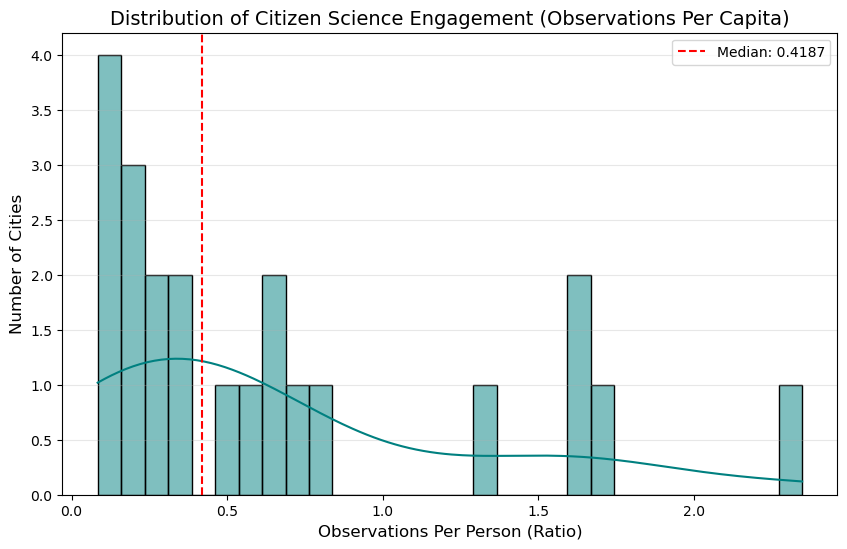

Cities with highest observations per capita:
           City  Obs_Per_Capita
20  minneapolis        2.348282
2       atlanta        1.681483
34        tampa        1.634861
19        miami        1.603496
25     portland        1.339286


In [88]:
# We sum the observations (to get the total) but take the mean/max of Population (since it's constant)
city_stats = final_df.groupby('City').agg({
    'Observation number all species': 'sum',
    'Population': 'max'  # Population doesn't change month-to-month, so max or mean works
}).reset_index()

# We use .replace() for exact whole-value matches
df_INat_Overall['City'] = df_INat_Overall['City'].replace('salt_lake_city', 'salt lake')

df_INat_Overall['City'] = df_INat_Overall['City'].str.replace('_', ' ')

# Create the Per Capita Metric
city_stats['Obs_Per_Capita'] = city_stats['Observation number all species'] / city_stats['Population']

plt.figure(figsize=(10, 6))
sns.histplot(city_stats['Obs_Per_Capita'], bins=30, kde=True, color='teal')

plt.title('Distribution of Citizen Science Engagement (Observations Per Capita)', fontsize=14)
plt.xlabel('Observations Per Person (Ratio)', fontsize=12)
plt.ylabel('Number of Cities', fontsize=12)

median_val = city_stats['Obs_Per_Capita'].median()
plt.axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.4f}')
plt.legend()

plt.grid(axis='y', alpha=0.3)
plt.show()

print("Cities with highest observations per capita:")
print(city_stats.sort_values('Obs_Per_Capita', ascending=False)[['City', 'Obs_Per_Capita']].head())

In [64]:

# Grouping by City
city_stats = final_df.groupby('City').agg({
    'Observation number all species': 'sum',
    'Population': 'max'  # Population doesn't change month-to-month, so max or mean works
}).reset_index()

sorted_cities = city_stats.sort_values('Observation number all species', ascending=False)


# Reset the index
ranked_list = sorted_cities[['City', 'Observation number all species']].reset_index(drop=True)
ranked_list.index += 1  # Start ranking at 1 instead of 0

print("Cities Ranked by Total Observations (High to Low):")
print(ranked_list)

Cities Ranked by Total Observations (High to Low):
              City  Observation number all species
1      los_angeles                         3130889
2      minneapolis                         1016402
3      san_antonio                          925596
4         new_york                          924390
5         portland                          886034
6          atlanta                          882873
7    san_francisco                          775225
8            miami                          732384
9            tampa                          662874
10          dallas                          633053
11         seattle                          623891
12         chicago                          621393
13         phoenix                          540468
14         detroit                          430218
15      sacramento                          391352
16     albuquerque                          351728
17        honolulu                          339307
18  salt_lake_city             

In [86]:
#Parks and Population density data for cities

df_INat_Overall= pd.read_csv('Overall Inat Proj 1.csv')

df_INat_Overall  = df_INat_Overall.map(lowercase)

df_INat_Overall['City'] = df_INat_Overall['City'].replace('salt_lake_city', 'salt lake')

# Replace all underscores with spaces in the entire 'City' column
df_INat_Overall['City'] = df_INat_Overall['City'].str.replace('_', ' ')

# Merge on BOTH 'Month' and 'City'
df_pop_overall = pd.merge(df_INat_Overall, df_City_park_Density, on=['City'], how='left')

# Create a list of the exact 3 column names you want to keep
columns_to_keep = ['City', 'Observation number all species', 'Species diversity count','Population']

df_pop_overall = df_pop_overall[columns_to_keep]

print(df_pop_overall.head(50))

df_pop_overall.to_csv('df_pop_overall.csv', index=False)

             City  Observation number all species  Species diversity count  \
0     albuquerque                          240970                     6854   
1       anchorage                          102649                     4276   
2         atlanta                          882341                    14342   
3           boise                           87959                     4143   
4          boston                           61499                     4265   
5         buffalo                           10699                     2032   
6       charlotte                          118963                     7491   
7         chicago                          586155                    10254   
8          dallas                          570158                     9667   
9          denver                          190298                     6653   
10        detroit                          524359                    12519   
11         helena                            5289               

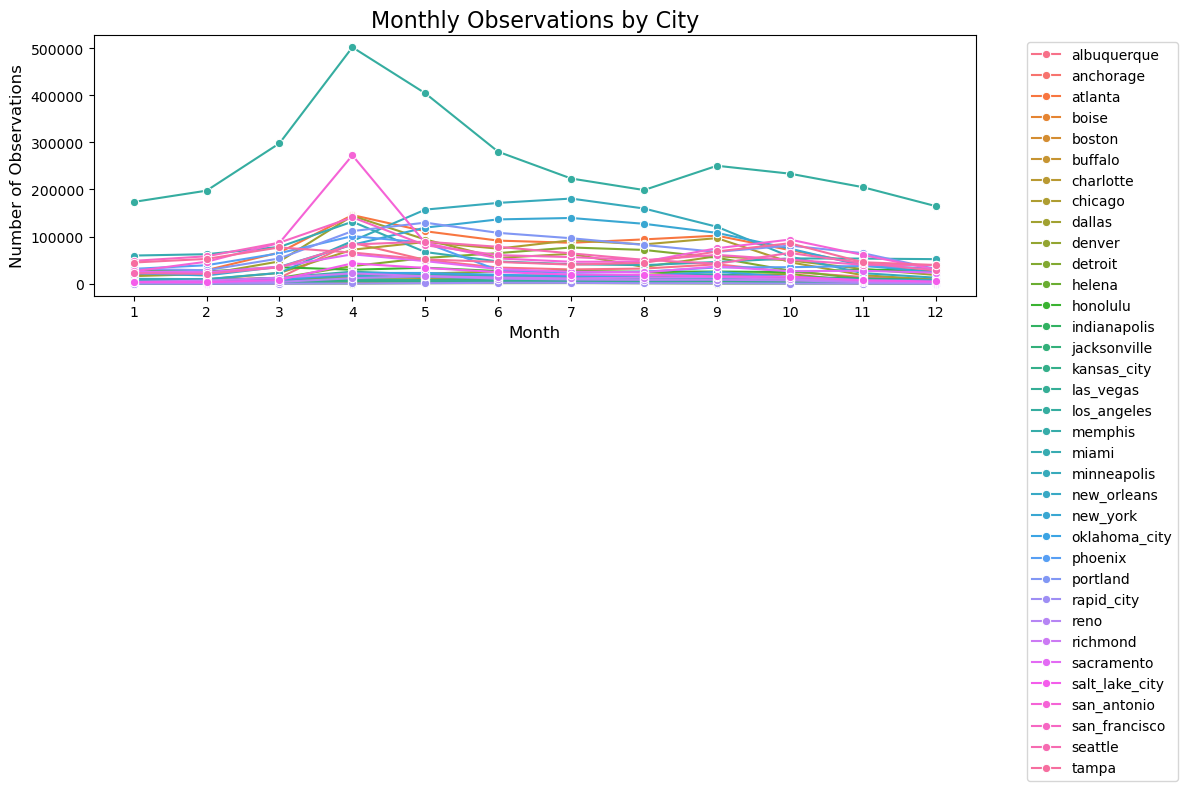

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the graph
plt.figure(figsize=(12, 6))

# Create the time series
# hue='City' creates a separate colored line for each city
sns.lineplot(
    data=df_city_month, 
    x='Month', 
    y='Observation number all species', 
    hue='City', 
    marker='o'  # Adds dots to the data points
)

# Customize labels and title
plt.title('Monthly Observations by City', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)

# Ensure the x-axis shows integers 1-12 explicitly
plt.xticks(range(1, 13))

# Move legend outside if there are many cities to avoid covering data
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

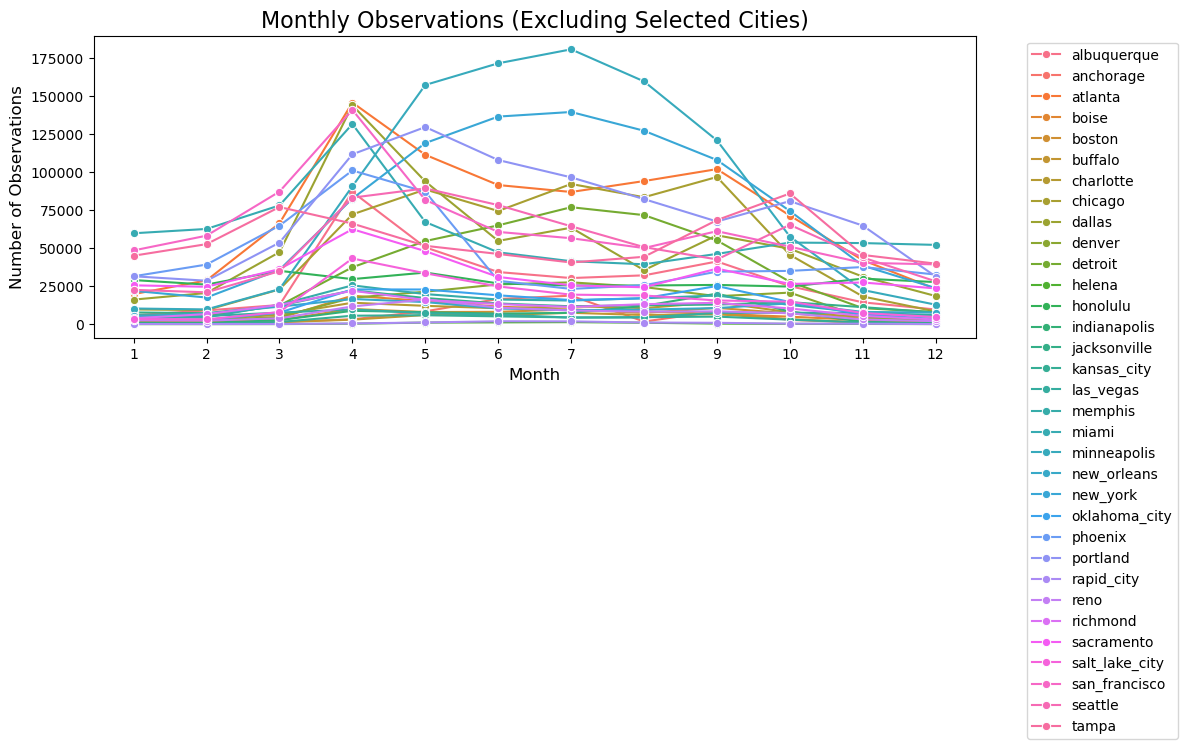

In [110]:

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a list of cities you want to remove
# Make sure these match the casing in your data (e.g., lowercase)
cities_to_exclude = ['los_angeles', 'san_antonio']


df_filtered = df_city_month[~df_city_month['City'].isin(cities_to_exclude)]

# 3. Create the plot with the filtered data
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df_filtered, 
    x='Month', 
    y='Observation number all species', 
    hue='City', 
    marker='o'
)

plt.title('Monthly Observations (Excluding Selected Cities)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)
plt.xticks(range(1, 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()